<a href="https://colab.research.google.com/github/seschm/Internship-Gaertner/blob/main/Complete_Reproduction_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit, vmap, pmap, grad
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import torch.utils.data as data

from tqdm.auto import tqdm
import random as rng

import numpy as np
import scipy as sp
from numpy import sqrt, cos, sin, exp, pi, log2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from scipy.stats import norm

In [2]:
def generate_random_pure_state(nQubit):
    """
    Generates Haar random pure state.
    To generate a random pure state, take any basis state, e.g. |00...00>
    and apply a random unitary matrix. For consistency each basis state should be the same.
    """
    baseRho=np.zeros((2**nQubit,2**nQubit),dtype=complex)
    baseRho[0,0]=1
    U=unitary_group.rvs(2**nQubit)
    return U@baseRho@U.conj().T

In [3]:
def generate_single_qubit(theta,phi):
    """
    Generates single qubit out of the given angles theta and phi.
    First construct the single qubit state as an array of shape (2, 1).
    Then compute the matrixproduct with its adjoint state.
    """
    state = np.array([[cos(theta/2)],[sin(theta/2)*exp(phi*1.j)]])
    return state@state.conj().T

In [4]:
def generate_random_seperable_pure_state(nQubit):
    """
    Generates random seperable pure state.
    First generate the desired number of random pure states.
    Then tensor them together.
    """
    single_qubits = []
    for i in range(0,nQubit):
        single_qubits.append(generate_random_pure_state(1))
    tensored_qubits = [single_qubits[0]]
    for i in range(1,nQubit):
        tensored_qubits.append(np.kron(tensored_qubits[-1],single_qubits[i]))
    return tensored_qubits[-1]

In [5]:
def depolarizing_channel(state,p):
    """
    Applies a depolarizing channel to the given state with p the probability of the completely mixed state.
    """
    d=len(state[0])
    return p*np.eye(d)/d+(1-p)*state

In [6]:
def generate_POVM(theta,phi,nQubit):
    """
    Generates a POVM consisting of multi qubit projectors on to the axis defined by the two angles theta and phi.
    First generates all possible states (combinations of spin up and down) as strings containing 1s and 0s.
    The order is equal to binary counting.
    Then generates the single qubit projector and its orthogonal projector.
    In the next step all single qubit projectors corresponding to the same state are gathered in the correct order and then tensored together to get an element of the POVM.
    Returns the POVM with the elements beeing ordered equal to binary counting (-> up ... up, up ... up down, up ... up down up, ...).
    """
    up_and_downs = []

    for i in range(2**nQubit):
        binary = bin(i)[2:]
        zeros = np.zeros(nQubit-len(binary), dtype=int)
        for k in range(nQubit-len(binary)):
            binary = '0' + binary
        up_and_downs.append(binary)

    projector=generate_single_qubit(theta,phi)
    orthogonal_projector = np.eye(2)-projector
    POVM = []

    for i in range(2**nQubit):
        tensored_projector = []
        single_projectors = []
        for j in range(nQubit):
            if up_and_downs[i][j] == '0':
                single_projectors.append(projector)
            if up_and_downs[i][j] == '1':
                single_projectors.append(orthogonal_projector)
        tensored_projector.append(single_projectors[0])
        for k in range(nQubit-1):
            tensored_projector.append(np.kron(tensored_projector[-1],single_projectors[k+1]))
        POVM.append(tensored_projector[-1])

    return POVM

In [7]:
def perform_multi_qubit_measurement(state,POVM):
    """
    Performs a multi qubit measurement with the given POVM.
    """
    probabilities = []
    for element in POVM:
        probabilities.append(np.trace(element@state))
    return probabilities

In [8]:
def perform_noisy_multi_qubit_measurement(state,POVM,p):
    """
    Generates probabilities of the noisy state.
    First applies the noise, then generates the probabilities.
    """
    noisy_state = depolarizing_channel(state,p)
    return perform_multi_qubit_measurement(noisy_state,POVM)

In [9]:
def sampling(probabilities,samplesize):
    """
    Takes in a probability distribution and samples from it.
    """
    sampling = rng.choices(np.arange(0,len(probabilities)), weights=probabilities, k=samplesize)
    sampled_probabilities = []
    for element in np.arange(0,len(probabilities)):
        sampled_probabilities.append(sampling.count(element)/samplesize)
    return sampled_probabilities

In [10]:
def MLE(nQubits,calibration_states,noisy_probabilities,POVM_ideal,p,samplesize):
    '''
    calibration_states: axis 0 = state, axis 1 = row, axis 2 = column
    noisy_probabilities: axis 0 = state, axis 1 = probabilities
    POVM_ideal / _reconstructed: axis 0 = element, axis 1 = row, axis 2 = column
    numb_of_detections: axis 0 = POVM_element, axis 1 = states, values = counts
    p_ideal: axis 0 = POVM_element, axis 1 = states, values = current ideal probability
    fracs: axis 0 = POVM_element, axis 1 = states, values = fractions

    '''

    numb_of_detections = noisy_probabilities.T * samplesize

    loop_num = 0
    loop_max = 2*10**3
    dist = 1
    dist_min = 10**-9

    POVM_reconstructed = np.array([p/2**nQubits*np.eye(2**nQubits) + (1-p)*POVM_elem for POVM_elem in POVM_ideal])

    while loop_num < loop_max and dist > dist_min:

        p_ideal = np.array([perform_multi_qubit_measurement(state,POVM_reconstructed) for state in calibration_states]).T
        fracs = numb_of_detections/p_ideal

        G = np.einsum('lm,ln,nij,ljk,mko->io',fracs,fracs,calibration_states,POVM_reconstructed,calibration_states,optimize=True)

        eig_vals,U = sp.linalg.eig(G)
        l_sqrt_inv = np.diag(1/np.sqrt(eig_vals))
        l_inv = U@l_sqrt_inv@U.conj().T # -> why not as in paper: U_dagger L_sqrt U ???

        R = np.einsum('ij,lm,mjk->lik',l_inv,fracs,calibration_states,optimize=True)

        POVM_reconstruction_old = POVM_reconstructed
        #POVM_reconstructed = np.einsum('lij,ljk,lkm->lim',R,POVM_reconstructed,R.conj().T)
        POVM_reconstructed = np.einsum('lij,ljk,lmk->lim',R,POVM_reconstructed,R.conj(),optimize=True)

        dist = np.sum([np.linalg.norm(POVM_reconstructed-POVM_reconstruction_old)])

        #if loop_num % (120/nQubit) == 0:
        if loop_num % 50 == 0:
            print(f'loop number: {loop_num}, distance: {dist}')

        loop_num += 1

    print(f'final loop number: {loop_num}, final distance: {dist}')

    return POVM_reconstructed, dist

In [11]:
def loss_fn(state, params, batch_input, batch_target_output):
    predictions = state.apply_fn(params, batch_input)
    #loss = jnp.mean(optax.softmax_cross_entropy(predictions,batch_target_output))
    loss = jnp.mean(-jnp.sum(batch_target_output*jax.lax.log(predictions),axis=1))
    return loss

In [12]:
@jax.jit
def accuracy_MSE(acc_input, acc_target_output,nQubit):
  acc = jnp.mean(jnp.sum(jnp.abs(acc_input-acc_target_output)**2,axis=-1)/(2**nQubit))
  return acc

In [13]:
@jax.jit
def accuracy_KLD(acc_input, acc_target_output):
  acc = jnp.mean(jnp.sum(acc_target_output*jnp.log(acc_target_output/acc_input),axis=-1))
  return acc

In [14]:
@jax.jit
def accuracy_IF(acc_input, acc_target_output):
  acc = jnp.mean(1-(jnp.sum(jnp.sqrt(acc_target_output*acc_input),axis=-1))**2)
  return acc

In [15]:
def linear_inversion(nQubit,calibration_states,calibration_probabilities,POVM,p,samplesize,desired_probabilities,test_probs,desired_test_probs):
    '''

    '''

    POVM_recon, dist = MLE(nQubit,calibration_states,calibration_probabilities,POVM,p,samplesize)

    L = np.zeros((2**nQubit,2**nQubit))

    for i in range(2**nQubit):
        for j in range(2**nQubit):
            L[j][i] = POVM_recon[i][j][j]

    L_inv = np.linalg.inv(L)

    probs_cor = np.einsum('ij,lj->li',L_inv,test_probs,optimize=True)
    probs_cor_tr = np.einsum('ij,lj->li',L_inv,calibration_probabilities,optimize=True)

    acc_MSE = accuracy_MSE(probs_cor, desired_test_probs,nQubit)
    acc_MSE_tr = accuracy_MSE(probs_cor_tr, desired_probabilities,nQubit)

    acc_KLD = accuracy_KLD(probs_cor, desired_test_probs)
    acc_KLD_tr = accuracy_KLD(probs_cor_tr, desired_probabilities)

    acc_IF = accuracy_IF(probs_cor, desired_test_probs)
    acc_IF_tr = accuracy_IF(probs_cor_tr, desired_probabilities)

    return POVM_recon, probs_cor, [acc_MSE,acc_MSE_tr], [acc_KLD,acc_KLD_tr], [acc_IF,acc_IF_tr]

In [16]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch_input, batch_target_output):
    # Gradient function
    grad_fn = jax.value_and_grad(loss_fn,# Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, batch_input, batch_target_output)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [17]:
def train_model(state, batched_training_input, batched_training_target_outputs, acc_input, acc_target_output,nQubit, num_epochs = 100):

  acc_test_MSE = []
  acc_training_MSE = []
  acc_unmitigated_test_MSE = []

  acc_test_KLD = []
  acc_training_KLD = []
  acc_unmitigated_test_KLD = []

  acc_test_IF = []
  acc_training_IF = []
  acc_unmitigated_test_IF = []

  for epoch in tqdm(range(num_epochs)):
    for i in range(len(batched_training_input)):
      state, loss = train_step(state, batched_training_input[i], batched_training_target_outputs[i])

    predictions_test = state.apply_fn(state.params, acc_input)
    predictions_training = state.apply_fn(state.params, batched_training_input)

    acc_test_MSE.append(accuracy_MSE(predictions_test, acc_target_output,nQubit))
    acc_training_MSE.append(accuracy_MSE(predictions_training, batched_training_target_outputs,nQubit))
    acc_unmitigated_test_MSE.append(accuracy_MSE(acc_input, acc_target_output,nQubit))

    acc_test_KLD.append(accuracy_KLD(predictions_test, acc_target_output))
    acc_training_KLD.append(accuracy_KLD(predictions_training, batched_training_target_outputs))
    acc_unmitigated_test_KLD.append(accuracy_KLD(acc_input, acc_target_output))

    acc_test_IF.append(accuracy_IF(predictions_test, acc_target_output))
    acc_training_IF.append(accuracy_IF(predictions_training, batched_training_target_outputs))
    acc_unmitigated_test_IF.append(accuracy_IF(acc_input, acc_target_output))

  return state, [acc_test_MSE, acc_training_MSE, acc_unmitigated_test_MSE], [acc_test_KLD, acc_training_KLD, acc_unmitigated_test_KLD], [acc_test_IF, acc_training_IF, acc_unmitigated_test_IF]

In [18]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [19]:
class MLP(nn.Module):

  num_neurons_per_layer : list[int]   # List containing the number of neurons per layer (except input layer)


  @nn.compact
  def __call__(self, x):
    activation = x
    for i, numb_neurons in enumerate(self.num_neurons_per_layer):
      activation = nn.Dense(numb_neurons)(activation) # tell how to initialize weigths -> reduce variance
      if i != len(self.num_neurons_per_layer) - 1:
        activation = nn.relu(activation)
    return jax.nn.softmax(activation)

  0%|          | 0/1800 [00:00<?, ?it/s]

/usr/lib/python3.10/random.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  if not _isfinite(total):
<ipython-input-20-89fb4c419051>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-20-89fb4c419051>:56: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.0009765705661995644
loop number: 60, distance: 2.0369840635209914e-06
loop number: 120, distance: 1.0507711290603954e-07
loop number: 180, distance: 5.483003630959013e-09
final loop number: 216, final distance: 9.815850680084385e-10


<ipython-input-15-b5a8940cab8a>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j]


  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

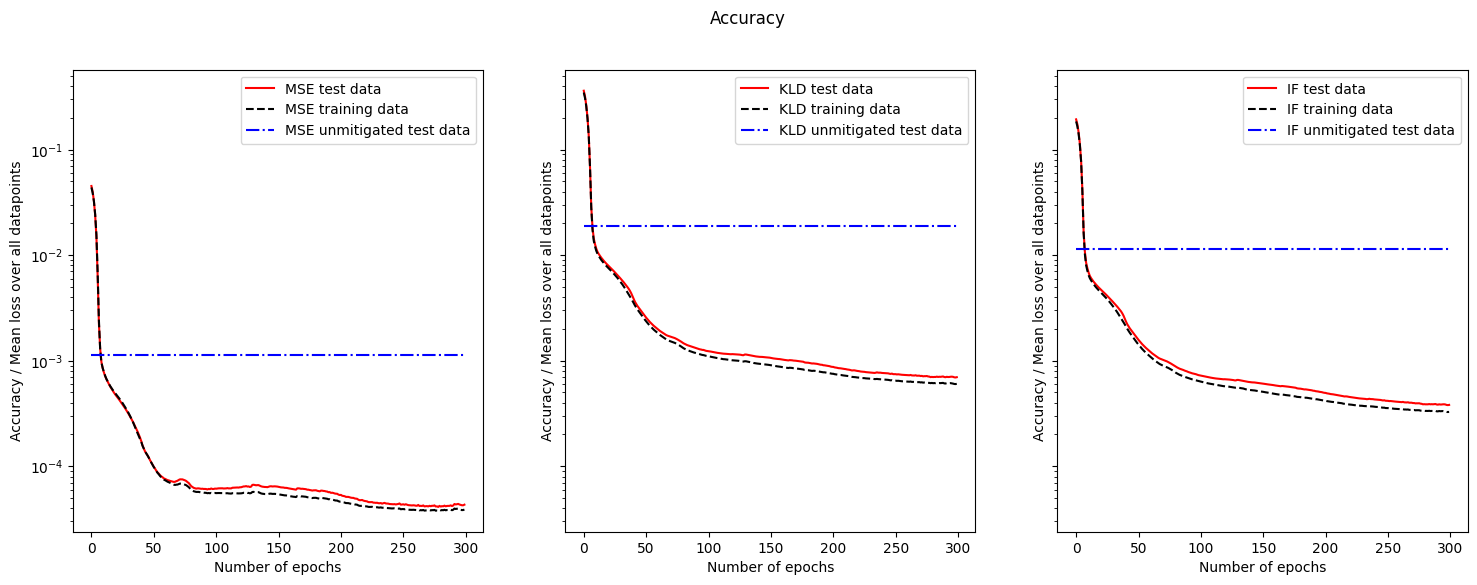

In [20]:
nQubit = 2
layers = [20,20,20,20,20,2**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 0.001
training_states = 1800
test_states = 200
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

calibration_states_list = []
calibration_probs_list = []
desired_probs_list = []
test_probs_list = []
desired_test_probs_list = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    calibration_states_list.append(state)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    calibration_probs_list.append(noisy_probs_sampled)
    desired_probs_list.append(probs)
    for j in range(2**nQubit):
        training_data[i][j] = noisy_probs_sampled[j]
        #training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs_list.append(noisy_probs_sampled)
    desired_test_probs_list.append(probs)
    for j in range(2**nQubit):
        test_data[i][j] = noisy_probs_sampled[j]
        #test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

calibration_states = np.asarray(calibration_states_list)
calibration_probs = np.asarray(calibration_probs_list)
desired_probs = np.asarray(desired_probs_list)
test_probs = np.asarray(test_probs_list)
desired_test = np.asarray(desired_test_probs_list)

POVM2, P2, MSE_data_LI2, KLD_data_LI2, IF_data_LI2 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
trained_model_state2, MSE_data2, KLD_data2, IF_data2 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                               batched_test_inp, batched_test_tar_out,
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data2[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data2[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data2[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data2[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data2[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data2[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data2[0],label="IF test data",color="red")
axs[2].plot(i,IF_data2[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data2[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

In [21]:
print(MSE_data_LI2, KLD_data_LI2, IF_data_LI2)
#print(POVM2)
for element in POVM2:
  print(np.all(np.linalg.eigvals(element) > 0))

[Array(2.3012946e-05, dtype=float32), Array(2.0961825e-05, dtype=float32)] [Array(0.00029962-0.00019646j, dtype=complex64), Array(0.00034956-0.00010046j, dtype=complex64)] [Array(0.00019015-0.00011587j, dtype=complex64), Array(0.00018568-4.5335444e-05j, dtype=complex64)]
True
True
True
True


  0%|          | 0/3800 [00:00<?, ?it/s]

<ipython-input-23-039fbd140292>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-23-039fbd140292>:56: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.0028869860995262516
loop number: 40, distance: 6.496039625718021e-05
loop number: 80, distance: 2.489683780867385e-05
loop number: 120, distance: 1.1387565446143668e-05
loop number: 160, distance: 5.449136789872091e-06
loop number: 200, distance: 2.6489356682161183e-06
loop number: 240, distance: 1.2984548156196248e-06
loop number: 280, distance: 6.402208508415334e-07
loop number: 320, distance: 3.171759174659756e-07
loop number: 360, distance: 1.5778124071041468e-07
loop number: 400, distance: 7.877651105025526e-08
loop number: 440, distance: 3.946109532308221e-08
loop number: 480, distance: 1.9826378337782717e-08
loop number: 520, distance: 9.988676618146255e-09
loop number: 560, distance: 5.045039173715763e-09
loop number: 600, distance: 2.554025812192099e-09
loop number: 640, distance: 1.2957206629866344e-09
final loop number: 657, final distance: 9.88254689306625e-10


<ipython-input-15-b5a8940cab8a>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j]


  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

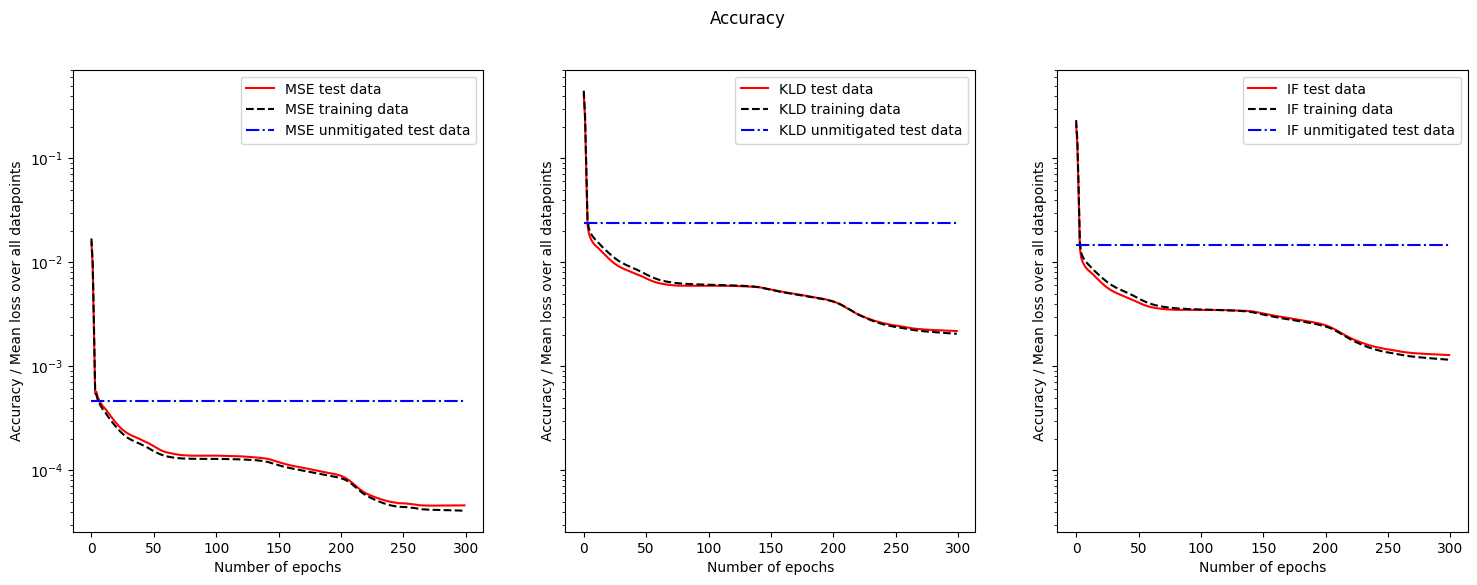

In [23]:
nQubit = 3
layers = [40,40,2**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 0.001
training_states = 3800
test_states = 200
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

calibration_states_list = []
calibration_probs_list = []
desired_probs_list = []
test_probs_list = []
desired_test_probs_list = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    calibration_states_list.append(state)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    calibration_probs_list.append(noisy_probs_sampled)
    desired_probs_list.append(probs)
    for j in range(2**nQubit):
        training_data[i][j] = noisy_probs_sampled[j]
        #training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs_list.append(noisy_probs_sampled)
    desired_test_probs_list.append(probs)
    for j in range(2**nQubit):
        test_data[i][j] = noisy_probs_sampled[j]
        #test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

calibration_states = np.asarray(calibration_states_list)
calibration_probs = np.asarray(calibration_probs_list)
desired_probs = np.asarray(desired_probs_list)
test_probs = np.asarray(test_probs_list)
desired_test = np.asarray(desired_test_probs_list)

POVM3, P3, MSE_data_LI3, KLD_data_LI3, IF_data_LI3 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
trained_model_state3, MSE_data3, KLD_data3, IF_data3 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                               batched_test_inp, batched_test_tar_out,
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data3[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data3[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data3[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data3[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data3[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data3[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data3[0],label="IF test data",color="red")
axs[2].plot(i,IF_data3[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data3[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

In [ ]:
nQubit = 4
layers = [80,80,80,80,80,80,80,2**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 5*10**-5
training_states = 7800
test_states = 200
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

calibration_states_list = []
calibration_probs_list = []
desired_probs_list = []
test_probs_list = []
desired_test_probs_list = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    calibration_states_list.append(state)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    calibration_probs_list.append(noisy_probs_sampled)
    desired_probs_list.append(probs)
    for j in range(2**nQubit):
        training_data[i][j] = noisy_probs_sampled[j]
        #training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs_list.append(noisy_probs_sampled)
    desired_test_probs_list.append(probs)
    for j in range(2**nQubit):
        test_data[i][j] = noisy_probs_sampled[j]
        #test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

calibration_states = np.asarray(calibration_states_list)
calibration_probs = np.asarray(calibration_probs_list)
desired_probs = np.asarray(desired_probs_list)
test_probs = np.asarray(test_probs_list)
desired_test = np.asarray(desired_test_probs_list)

POVM4, P4, MSE_data_LI4, KLD_data_LI4, IF_data_LI4 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
trained_model_state4, MSE_data4, KLD_data4, IF_data4 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                               batched_test_inp, batched_test_tar_out,
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data4[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data4[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data4[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data4[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data4[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data4[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data4[0],label="IF test data",color="red")
axs[2].plot(i,IF_data4[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data4[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

  0%|          | 0/7800 [00:00<?, ?it/s]

<ipython-input-24-1800224643d4>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-24-1800224643d4>:56: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


loop number: 0, distance: 0.005305663975900672
loop number: 30, distance: 0.0002405959564585496
loop number: 60, distance: 0.00014239020561629414
loop number: 90, distance: 9.90408657618137e-05
loop number: 120, distance: 7.404025227649028e-05
loop number: 150, distance: 5.748288281695896e-05
loop number: 180, distance: 4.560125176545654e-05
loop number: 210, distance: 3.666952033409796e-05
loop number: 240, distance: 2.9762137005950026e-05
loop number: 270, distance: 2.4319695199569565e-05
loop number: 300, distance: 1.997499344935124e-05
loop number: 330, distance: 1.6473028549831088e-05
loop number: 360, distance: 1.3629523982752879e-05
loop number: 390, distance: 1.1307352251586588e-05
loop number: 420, distance: 9.402172680838167e-06
loop number: 450, distance: 7.833208956459324e-06
loop number: 480, distance: 6.537072707744142e-06
loop number: 510, distance: 5.4634810682528205e-06
loop number: 540, distance: 4.572199872622807e-06
loop number: 570, distance: 3.830807765495874e-06


In [ ]:
nQubit = 5
layers = [160,160,160,160,160,2**nQubit]
num_epochs = 300
batch_size = 100
learning_rate = 5*10**-5
training_states = 9900 # originally 9850 but adapted to the batch size
test_states = 200
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15
samplesize = 10000

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

calibration_states_list = []
calibration_probs_list = []
desired_probs_list = []
test_probs_list = []
desired_test_probs_list = []

for i in tqdm(range(training_states)):
    state = generate_random_seperable_pure_state(nQubit)
    calibration_states_list.append(state)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    calibration_probs_list.append(noisy_probs_sampled)
    desired_probs_list.append(probs)
    for j in range(2**nQubit):
        training_data[i][j] = noisy_probs_sampled[j]
        #training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_seperable_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    noisy_probs_sampled = sampling(noisy_probs,samplesize)
    test_probs_list.append(noisy_probs_sampled)
    desired_test_probs_list.append(probs)
    for j in range(2**nQubit):
        test_data[i][j] = noisy_probs_sampled[j]
        #test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

calibration_states = np.asarray(calibration_states_list)
calibration_probs = np.asarray(calibration_probs_list)
desired_probs = np.asarray(desired_probs_list)
test_probs = np.asarray(test_probs_list)
desired_test = np.asarray(desired_test_probs_list)

POVM5, P5, MSE_data_LI5, KLD_data_LI5, IF_data_LI5 = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
trained_model_state5, MSE_data5, KLD_data5, IF_data5 = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                               batched_test_inp, batched_test_tar_out,
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data5[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data5[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data5[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data5[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data5[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data5[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data5[0],label="IF test data",color="red")
axs[2].plot(i,IF_data5[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data5[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

In [ ]:
labels = ["2 Qubits","3 Qubits","4 Qubits","5 Qubits"]
MSE_data_LI5, KLD_data_LI5, IF_data_LI5
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

axs[0].bar(0,MSE_data2[2][-1],label="unmitigated test data",color="black")
axs[0].bar(1,MSE_data2[1][-1],label="NN training data",color="red")
axs[0].bar(2,MSE_data2[0][-1],label="NN test data",color="blue")
axs[0].bar(3,MSE_data_LI2[1],label="NN training data",color="orange")
axs[0].bar(4,MSE_data_LI2[0],label="NN test data",color="green")
axs[0].bar(7,MSE_data3[2][-1],color="black")
axs[0].bar(8,MSE_data3[1][-1],color="blue")
axs[0].bar(9,MSE_data3[0][-1],color="red")
axs[0].bar(10,MSE_data_LI3[1],color="orange")
axs[0].bar(11,MSE_data_LI3[0],color="green")
axs[0].bar(14,MSE_data4[2][-1],color="black")
axs[0].bar(15,MSE_data4[1][-1],color="blue")
axs[0].bar(16,MSE_data4[0][-1],color="red")
axs[0].bar(17,MSE_data_LI4[1],color="orange")
axs[0].bar(18,MSE_data_LI4[0],color="green")
axs[0].bar(21,MSE_data5[2][-1],color="black")
axs[0].bar(22,MSE_data5[1][-1],color="blue")
axs[0].bar(23,MSE_data5[0][-1],color="red")
axs[0].bar(24,MSE_data_LI3[1],color="orange")
axs[0].bar(25,MSE_data_LI3[0],color="green")
axs[0].set_xticks([2,9,16,23])
axs[0].set_xticklabels(labels)
axs[0].set_xlabel("MSE")
axs[0].set_ylabel("accuracy")
axs[0].legend()

axs[1].bar(0,KLD_data[2][-1],label="unmitigated test data",color="black")
axs[1].bar(1,KLD_data[1][-1],label="NN training data",color="red")
axs[1].bar(2,KLD_data[0][-1],label="NN test data",color="blue")
axs[1].bar(3,KLD_data_LI2[1],label="NN training data",color="orange")
axs[1].bar(4,KLD_data_LI2[0],label="NN test data",color="green")
axs[1].bar(7,KLD_data3[2][-1],color="black")
axs[1].bar(8,KLD_data3[1][-1],color="blue")
axs[1].bar(9,KLD_data3[0][-1],color="red")
axs[1].bar(10,KLD_data_LI3[1],color="orange")
axs[1].bar(11,KLD_data_LI3[0],color="green")
axs[1].bar(14,KLD_data4[2][-1],color="black")
axs[1].bar(15,KLD_data4[1][-1],color="blue")
axs[1].bar(16,KLD_data4[0][-1],color="red")
axs[1].bar(17,KLD_data_LI4[1],color="orange")
axs[1].bar(18,KLD_data_LI4[0],color="green")
axs[1].bar(21,KLD_data5[2][-1],color="black")
axs[1].bar(22,KLD_data5[1][-1],color="blue")
axs[1].bar(23,KLD_data5[0][-1],color="red")
axs[1].bar(24,KLD_data_LI3[1],color="orange")
axs[1].bar(25,KLD_data_LI3[0],color="green")
axs[1].set_xticks([2,9,16,23])
axs[1].set_xticklabels(labels)
axs[1].set_xlabel("KLD")
axs[1].set_ylabel("accuracy")
axs[1].legend()

axs[2].bar(0,IF_data[2][-1],label="unmitigated test data",color="black")
axs[2].bar(1,IF_data[1][-1],label="NN training data",color="red")
axs[2].bar(2,IF_data[0][-1],label="NN test data",color="blue")
axs[2].bar(3,IF_data_LI2[1],label="NN training data",color="orange")
axs[2].bar(4,IF_data_LI2[0],label="NN test data",color="green")
axs[2].bar(7,IF_data3[2][-1],color="black")
axs[2].bar(8,IF_data3[1][-1],color="blue")
axs[2].bar(9,IF_data3[0][-1],color="red")
axs[2].bar(10,IF_data_LI3[1],color="orange")
axs[2].bar(11,IF_data_LI3[0],color="green")
axs[2].bar(14,IF_data4[2][-1],color="black")
axs[2].bar(15,IF_data4[1][-1],color="blue")
axs[2].bar(16,IF_data4[0][-1],color="red")
axs[2].bar(17,IF_data_LI4[1],color="orange")
axs[2].bar(18,IF_data_LI4[0],color="green")
axs[2].bar(21,IF_data5[2][-1],color="black")
axs[2].bar(22,IF_data5[1][-1],color="blue")
axs[2].bar(23,IF_data5[0][-1],color="red")
axs[2].bar(24,IF_data_LI3[1],color="orange")
axs[2].bar(25,IF_data_LI3[0],color="green")
axs[2].set_xticks([2,9,16,23])
axs[2].set_xticklabels(labels)
axs[2].set_xlabel("IF")
axs[2].set_ylabel("accuracy")
axs[2].legend()

fig.suptitle('NN vs LI improvement')